# Лабораторная работа 3. Классификация. Нейронные сети
## 1. Введение
**Цель работы:** изучение методов классификации данных, реализованные в библиотеке Scikit-Learn, а также ознакомление с нейронными сетями с использованием библиотек TensorFlow и TensorBoard. 

**Задачи:**
1. Необходимо выбрать и подготовить датасет для классификации, затем построить классификационные модели с помощью пяти методов:

    a. Наивный Байесовский классификатор (GaussianNB, MultinomialNB, ComplementNB, BernoulliNB);

    b. Деревья решений (Decision Tree);

    c. Линейный дискриминантный анализ (Linear Discriminant Analysis);

    d. Метод опорных векторов (Support Vector Machines);

    e. Метод ближайших соседей (k-Nearest Neighbors);
2. Затем сравните качество работы классификаторов с помощью следующих метрик:

    a. Accuracy (точность),

    b. Precision (доля правильно классифицированных положительных примеров),

    c. Recall (чувствительность, доля верно найденных положительных примеров),

    d. F1-Score (среднее гармоническое precision и recall),

    e. Площадь под кривой ROC (AUC-ROC).

3. Настройте гиперпараметры каждого метода и проведите исследование влияния различных параметров на качество классификации.
4. Реализуйте и протестируйте нейронную сеть на TensorFlow, исследуйте эффект настройки гиперпараметров и визуализируйте процесс обучения с помощью инструмента TensorBoard.
## 2. Выбор и подготовка датасета
Датасет **Airline Passenger Satisfaction** содержит информацию об опыте пассажиров одной из международных авиакомпаний и используется для прогнозирования уровня их удовлетворённости полётом. Целевая задача — бинарная классификация: определить, удовлетворён ли пассажир (satisfied) или нет (neutral or dissatisfied). Датасет включает 129 880 записей (в полной версии) и 24 признака, описывающие демографические характеристики пассажиров (пол, возраст, тип клиента), детали рейса (класс обслуживания, цель поездки, расстояние), а также субъективные оценки различных аспектов сервиса (от 0 до 5), таких как комфорт кресел, качество еды, удобство онлайн-бронирования и другие. Некоторые записи содержат пропуски в признаке задержки прибытия.

Датасет содержит следующие признаки:

- Column1 — уникальный индентификатор строки. Не используется в моделировании.
- id — уникальный идентификатор пассажира. Не используется в моделировании.
- Gender — пол пассажира: "Male" (мужчина) или "Female" (женщина).
- Customer Type — тип клиента: "Loyal Customer" (лояльный, часто летает этой авиакомпанией) или "disloyal Customer" (нелояльный).
- Age — возраст пассажира в годах (целое число от 7 до 85).
- Type of Travel — цель поездки: "Business travel" (деловая поездка) или "Personal Travel" (личная поездка).
- Class — класс обслуживания: "Business", "Eco", или "Eco Plus".
- Flight Distance — расстояние полёта в километрах (числовое значение, от нескольких сотен до более чем 4000 км).
- Inflight wifi service — оценка качества Wi-Fi на борту по шкале от 0 до 5, где 0 — «не применимо» или «очень плохо», 5 — «отлично».
- Departure/Arrival time convenient — оценка удобства времени вылета и прилёта (0–5).
- Ease of Online booking — простота онлайн-бронирования билета (0–5).
- Gate location — удобство расположения выхода на посадку (0–5).
- Food and drink — качество еды и напитков на борту (0–5).
- Online boarding — удобство процесса онлайн-регистрации (0–5).
- Seat comfort — комфорт кресла (0–5).
- Inflight entertainment — качество развлекательных систем на борту (0–5).
- On-board service — качество обслуживания бортпроводников (0–5).
- Leg room service — пространство для ног в салоне (0–5).
- Baggage handling — качество обращения с багажом (регистрация, выдача и т.д.) (0–5).
- Checkin service — качество стойки регистрации в аэропорту (0–5).
- Inflight service — дополнительные услуги на борту (например, помощь с багажом, информирование) (0–5).
- Cleanliness — чистота салона самолёта (0–5).
- Departure Delay in Minutes — задержка вылета в минутах (неотрицательное число, может быть 0).
- Arrival Delay in Minutes — задержка прибытия в минутах (неотрицательное число). Содержит пропуски (около 300 значений в обучающей части).
- satisfaction — целевая переменная: "satisfied" (пассажир доволен) или "neutral or dissatisfied" (пассажир не доволен или нейтрален).

**Подготовка данных:**
- удалим первые два столбца;
- рандомно выберим 50 000 строк;
- заменим пропуски в Arrival Delay in Minutes;
- преобразуем целевую переменную в числовой формат;
- преобразуем категориальные переменные в целочисленный формат;
- стандартизируем не бинарные признаки

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import shutil
import datetime
import tensorflow as tf
layers = tf.keras.layers
models = tf.keras.models
optimizers = tf.keras.optimizers
EarlyStopping = tf.keras.callbacks.EarlyStopping
TensorBoard = tf.keras.callbacks.TensorBoard

from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv("Airline_Passenger_Satisfaction.csv")
df = df.drop(columns=['id', 'Unnamed: 0'])
df = df.sample(n=50000, random_state=42).reset_index(drop=True)

median_delay = df['Arrival Delay in Minutes'].median()
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(median_delay)

df['satisfaction'] = df['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

df_encoded = pd.get_dummies(df, columns=['Gender', 'Customer Type', 'Type of Travel', 'Class'], drop_first=True)

X = df_encoded.drop('satisfaction', axis=1)
y = df_encoded['satisfaction']

bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype(int)

binary_cols = []
for col in X.columns:
    if set(X[col].dropna().unique()) <= {0, 1}:
        binary_cols.append(col)

numeric_cols = [col for col in X.columns if col not in binary_cols]

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print(y.value_counts())
X.head()

satisfaction
0    28162
1    21838
Name: count, dtype: int64


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,-0.888046,-0.329380,-0.554895,0.614956,-0.544234,1.575454,1.348078,-0.93080,1.180876,1.227379,...,-0.242994,1.156585,1.301597,-0.387488,-0.392170,0,0,1,1,0
1,-1.152676,-0.799232,0.196364,1.271454,1.593033,1.575454,-0.154528,-0.18967,-0.336901,-0.272461,...,-1.035435,-0.542002,-0.220525,-0.387488,0.022108,1,0,0,0,0
2,1.295153,-0.997012,-1.306155,-0.041543,-1.256656,0.015506,-0.905831,-0.18967,-0.336901,0.477459,...,-0.242994,0.307291,0.540536,0.582712,0.488171,0,0,1,1,0
3,-0.491101,-0.169751,-0.554895,-0.041543,-0.544234,0.795480,0.596775,-0.93080,0.421988,0.477459,...,-1.827876,0.307291,0.540536,0.320496,-0.288601,0,0,1,1,0
4,-0.292628,-0.072367,-0.554895,-0.698042,-0.544234,-1.544442,-0.905831,-0.93080,1.180876,-1.022381,...,-1.035435,-1.391296,-0.981586,-0.387488,-0.392170,1,1,0,0,0


## 3. Разбиение выборки и балансировка
Разделим данные на обучающую (80%) и тестовую (20%) выборки и сбалансируем обучающую часть с помощью SMOTE.

**SMOTE** — это популярный метод борьбы с дисбалансом классов. В отличие от простого дублирования примеров из миноритарного класса, SMOTE генерирует новые синтетические примеры, интерполируя между существующими.

Для каждого объекта из миноритарного (редкого) класса:
1. Находятся его k ближайших соседей (обычно по евклидову расстоянию) среди других объектов того же класса.
2. Случайно выбирается один из этих соседей.
3. Новый синтетический объект создаётся на отрезке, соединяющем исходный объект и выбранного соседа:

$x_{\text{new}} = x_i + \delta \cdot (x_{zi} - x_i)$

где:
- $x_i$ — исходный объект из миноритарного класса,
- $x_{zi}$ — случайно выбранный сосед из того же класса,
- $\delta$— случайное число из отрезка $[0, 1]$.

Это означает, что новый объект будет находиться где-то между двумя реальными объектами миноритарного класса.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

satisfaction
1    22530
0    22530
Name: count, dtype: int64


## 4. Методы классификации и настройка гиперпараметров
### a. Наивный Байесовский классификатор
**Наивный Байес** - алгоритм классификации, основанный на теореме Байеса из теории вероятностей. Он отвечает на вопрос: Какова вероятность, что объект принадлежит к классу C, если мы знаем его признаки x₁, x₂, ..., xₙ?» И выбирает тот класс, у которого эта вероятность максимальна. Алгоритм делает предположение: Все признаки независимы друг от друга при условии известного класса. 

Благодаря предположению о независимости, формула имеет вид:

$ P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y) $

где:
- $ P(y) $ — априорная вероятность класса,
- $ P(x_i \mid y) $ — правдоподобие i-го признака при условии класса $ y $.

То есть:

Вероятность класса = априорная вероятность класса × произведение вероятностей каждого признака в этом классе.

Использовать будем **GaussianNB**, используется при числовых признаках (непрерывные).

**Ключевые гиперпараметры:**
- var_smoothing: добавляет небольшое положительное число ко всем дисперсиям, чтобы избежать экстремально малых значений.

$\sigma^2_{\text{new}} = \sigma^2 + \text{var\_smoothing} \cdot \sigma^2_{\text{max}}$

где:  
- $\sigma^2$ — исходная дисперсия признака в классе,  
- $\sigma^2_{\text{max}}$ — максимальная дисперсия среди всех признаков и классов,  
- $var\_smoothing$ — коэффициент сглаживания (по умолчанию 1e-9).

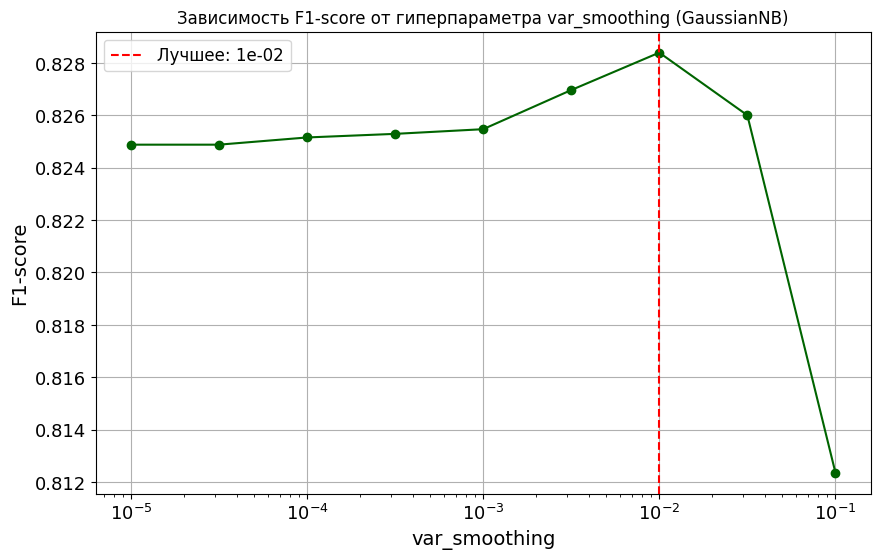


Лучшая модель GaussianNB при var_smoothing = 1e-02:
Accuracy: 0.8523
Precision: 0.8410
Recall: 0.8162
F1: 0.8284
AUC-ROC: 0.9141


In [14]:
results = []
var_smoothing_values = np.logspace(-5, -1, 9)

f1_scores = []
for vs in var_smoothing_values:
    nb = GaussianNB(var_smoothing=vs)
    nb.fit(X_train_balanced, y_train_balanced)
    y_pred = nb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_vs = var_smoothing_values[best_idx]
best_f1 = f1_scores[best_idx]

plt.figure(figsize=(10, 6))
plt.semilogx(var_smoothing_values, f1_scores, marker='o', linestyle='-', color='darkgreen')
plt.axvline(best_vs, color='red', linestyle='--', label=f'Лучшее: {best_vs:.0e}')
plt.xlabel('var_smoothing', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от гиперпараметра var_smoothing (GaussianNB)')
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

nb_best = GaussianNB(var_smoothing=best_vs)
nb_best.fit(X_train_balanced, y_train_balanced)

y_pred_best = nb_best.predict(X_test)
y_proba_best = nb_best.predict_proba(X_test)[:, 1]

metrics_nb = {
    'Model': 'GaussianNB',
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'F1': f1_score(y_test, y_pred_best),
    'AUC-ROC': roc_auc_score(y_test, y_proba_best)
}
results.append(metrics_nb)

print(f"\nЛучшая модель GaussianNB при var_smoothing = {best_vs:.0e}:")
for metric, value in metrics_nb.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

### b. Деревья решений
**Дерево решений** — метод для построения модели классификатора, которая напоминает блок-схему или «дерево вопросов»: на каждом шаге она задаёт вопрос о признаке объекта, и в зависимости от ответа — идёт влево или вправо, пока не дойдёт до конечного вывода (листа) — предсказания класса или значения.

На каждом шаге дерево ищет такой вопрос, который наилучшим образом разделяет объекты на однородные группы. Для этого используются мера неоднородности:

- **Индекс Джини** (Gini impurity) показывает, насколько часто случайно выбранный элемент будет неправильно классифицирован, если метку выбрать случайно по распределению в узле.

$\text{Gini} = 1 - \sum_{i=1}^{k} p_i^2$

где $ p_i $ — доля объектов класса $ i $ в узле.

**Ключевые гиперпараметры:**
- max_depth — максимальная глубина дерева (сколько вопросов можно задать);
- min_samples_split — минимальное число объектов для разделения узла;
- min_samples_leaf — минимальное число объектов в листе;
- max_features — количество признаков, рассматриваемых при поиске лучшего разбиения.

Мы исследуем влияние **max_depth** и **min_samples_split** на F1-score, так как они наиболее критичны для баланса между переобучением и недообучением.

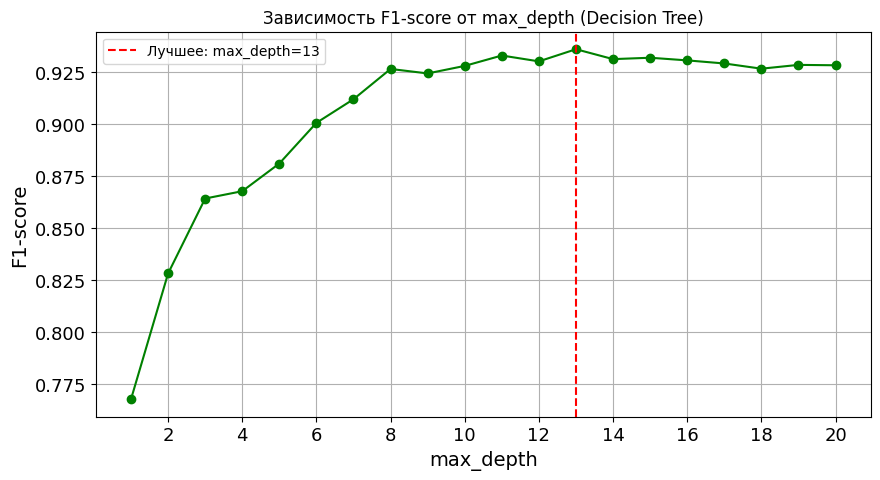

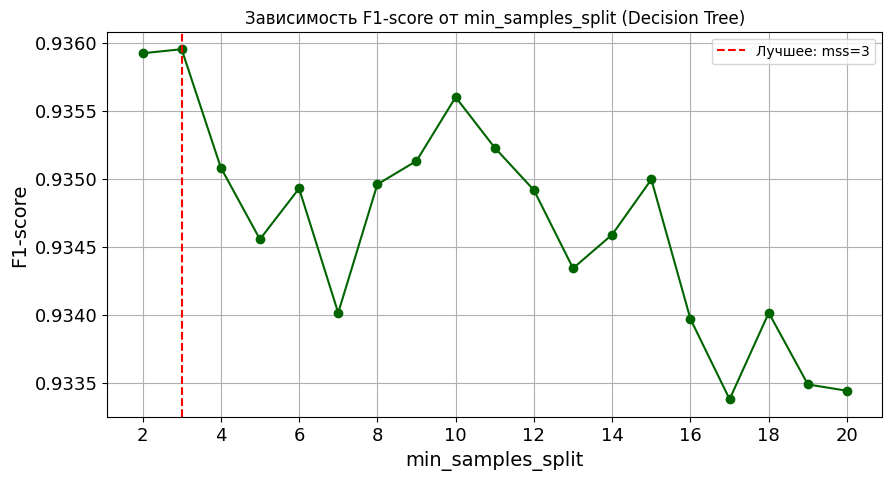


Лучшая модель Decision Tree при max_depth = 13, min_samples_split = 3
Accuracy: 0.9449
Precision: 0.9506
Recall: 0.9217
F1: 0.9360
AUC-ROC: 0.9649


In [15]:
max_depths = range(1, 21)

f1_depth = []
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train_balanced, y_train_balanced)
    y_pred = dt.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_depth.append(f1)

best_depth = max_depths[np.argmax(f1_depth)]
best_f1_depth = max(f1_depth)

plt.figure(figsize=(10, 5))
plt.plot(max_depths, f1_depth, marker='o', color='green')
plt.axvline(best_depth, color='red', linestyle='--', label=f'Лучшее: max_depth={best_depth}')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от max_depth (Decision Tree)')
plt.legend()
plt.grid(True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

min_samples_splits = range(2, 21)

f1_split = []
for mss in min_samples_splits:
    dt = DecisionTreeClassifier(
        max_depth=best_depth,
        min_samples_split=mss,
        random_state=42
    )
    dt.fit(X_train_balanced, y_train_balanced)
    y_pred = dt.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_split.append(f1)

best_mss = min_samples_splits[np.argmax(f1_split)]
best_f1_mss = max(f1_split)

plt.figure(figsize=(10, 5))
plt.plot(min_samples_splits, f1_split, marker='o', color='darkgreen')
plt.axvline(best_mss, color='red', linestyle='--', label=f'Лучшее: mss={best_mss}')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlabel('min_samples_split', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от min_samples_split (Decision Tree)')
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()

dt_best = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_mss,
    random_state=42
)
dt_best.fit(X_train_balanced, y_train_balanced)

y_pred_dt = dt_best.predict(X_test)
y_proba_dt = dt_best.predict_proba(X_test)[:, 1]

metrics_dt = {
    'Model': 'DecisionTree',
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1': f1_score(y_test, y_pred_dt),
    'AUC-ROC': roc_auc_score(y_test, y_proba_dt)
}
results.append(metrics_dt)

print(f"\nЛучшая модель Decision Tree при max_depth = {best_depth}, min_samples_split = {best_mss}")
for metric, value in metrics_dt.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

### c. Линейный дискриминантный анализ
**LDA** — это метод линейной классификации и снижения размерности, который ищет такое направление(или набор направлений) в пространстве признаков, вдоль которого: "Разделение между классами — максимально, а разброс внутри каждого класса — минимален".

Алгоритм:
1. Обучение:
- Вычисляются средние векторы для каждого класса: $μ_0$, $μ_1$.
- Строится общая ковариационная матрица $Σ$.
- Находится вектор весов $\mathbf{w} \propto \Sigma^{-1} (\mu_1 - \mu_0)$
2. Предсказание для нового объекта $x$:
- Вычисляется дискриминантная функция:

$\delta_k(\mathbf{x}) = \mathbf{x}^T \Sigma^{-1} \boldsymbol{\mu}_k - \frac{1}{2} \boldsymbol{\mu}_k^T \Sigma^{-1} \boldsymbol{\mu}_k + \log P(C_k)$

где:

$ \mathbf{x} $ — вектор признаков нового объекта,

$ \boldsymbol{\mu}_k $ — средний вектор класса $ k $,

$ \Sigma $ — общая ковариационная матрица (одинаковая для всех классов),

$ P(C_k) $ — априорная вероятность класса $ k $ (доля объектов класса $ k $ в обучающей выборке).
- Объект относится к тому классу $k$, у которого $\delta_k(\mathbf{x})$ максимальна.

В Scikit-Learn LDA поддерживает регуляризацию через параметр shrinkage, доступный при solver='lsqr' (метод наименьших квадратов с регуляризацией) или 'eigen' (метод собственных векторов).

**Ключевые гиперпараметры:**
- shrinkage — значение от 0 до 1, контролирующее степень регуляризации ковариационной матрицы. shrinkage=0 → без регуляризации, shrinkage=1 → полная регуляризация (диагональная матрица).

$\Sigma_{\text{new}} = (1 - \alpha) \cdot \Sigma + \alpha \cdot \operatorname{diag}(\Sigma)$

где $ \alpha = shrinkage$ .

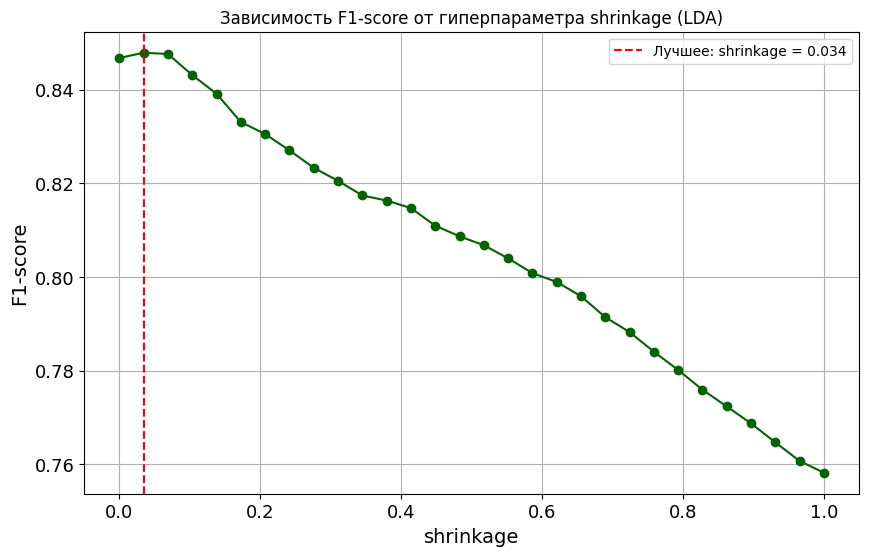


Лучшая модель LDA при shrinkage = 0.034
Accuracy: 0.8667
Precision: 0.8451
Recall: 0.8507
F1: 0.8479
AUC-ROC: 0.9224


In [17]:
shrinkage_values = np.linspace(0.0, 1.0, 30)

f1_scores_lda = []
for shrink in shrinkage_values:
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrink)
    lda.fit(X_train_balanced, y_train_balanced)
    y_pred = lda.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores_lda.append(f1)

best_shrinkage = shrinkage_values[np.argmax(f1_scores_lda)]
best_f1_lda = max(f1_scores_lda)

plt.figure(figsize=(10, 6))
plt.plot(shrinkage_values, f1_scores_lda, marker='o', linestyle='-', color='darkgreen')
plt.axvline(best_shrinkage, color='red', linestyle='--', label=f'Лучшее: shrinkage = {best_shrinkage:.3f}')
plt.xlabel('shrinkage', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Зависимость F1-score от гиперпараметра shrinkage (LDA)')
plt.legend()
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.show()

lda_best = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shrinkage)
lda_best.fit(X_train_balanced, y_train_balanced)

y_pred_lda = lda_best.predict(X_test)
y_proba_lda = lda_best.predict_proba(X_test)[:, 1]

metrics_lda = {
    'Model': 'LDA',
    'Accuracy': accuracy_score(y_test, y_pred_lda),
    'Precision': precision_score(y_test, y_pred_lda),
    'Recall': recall_score(y_test, y_pred_lda),
    'F1': f1_score(y_test, y_pred_lda),
    'AUC-ROC': roc_auc_score(y_test, y_proba_lda)
}

results.append(metrics_lda)

print(f"\nЛучшая модель LDA при shrinkage = {best_shrinkage:.3f}")
for metric, value in metrics_lda.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

### d. Метод опорных векторов
**SVM** — это метод классификации, который ищет такую гиперплоскость (линию, плоскость, поверхность), которая максимально далеко отстоит от ближайших объектов обоих классов. SVM выбирает ту линию, которая находится посередине между двумя облаками точек и максимально удалена от ближайших точек.

Для линейно разделимых данных SVM решает задачу:

$\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2$

при условии:

$y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 \quad \forall i$

Где:

- $\mathbf{w}$ — нормаль к разделяющей гиперплоскости,  
- $b$ — смещение,  
- $y_i \in \{-1, +1\}$ — метки классов.

**Ключевые гиперпараметры:**
- kernel — тип ядра: линейное (linear), радиальная базисная функция (rbf), полиномиальное (poly), сигмоид (sigmoid);
- C — параметр регуляризации (чем больше — тем меньше регуляризация);
- gamma — насколько далеко распространяется влияние одного обучающего примера;
- degree — степень полинома (Определяет сложность полиномиального ядра).

Мы протестируем 4 ядра:
1. linear → подбор C
2. rbf → подбор gamma (при фиксированном C=1)
3. poly → подбор degree (при C=1, gamma=1)
4. sigmoid → подбор gamma (при C=1)

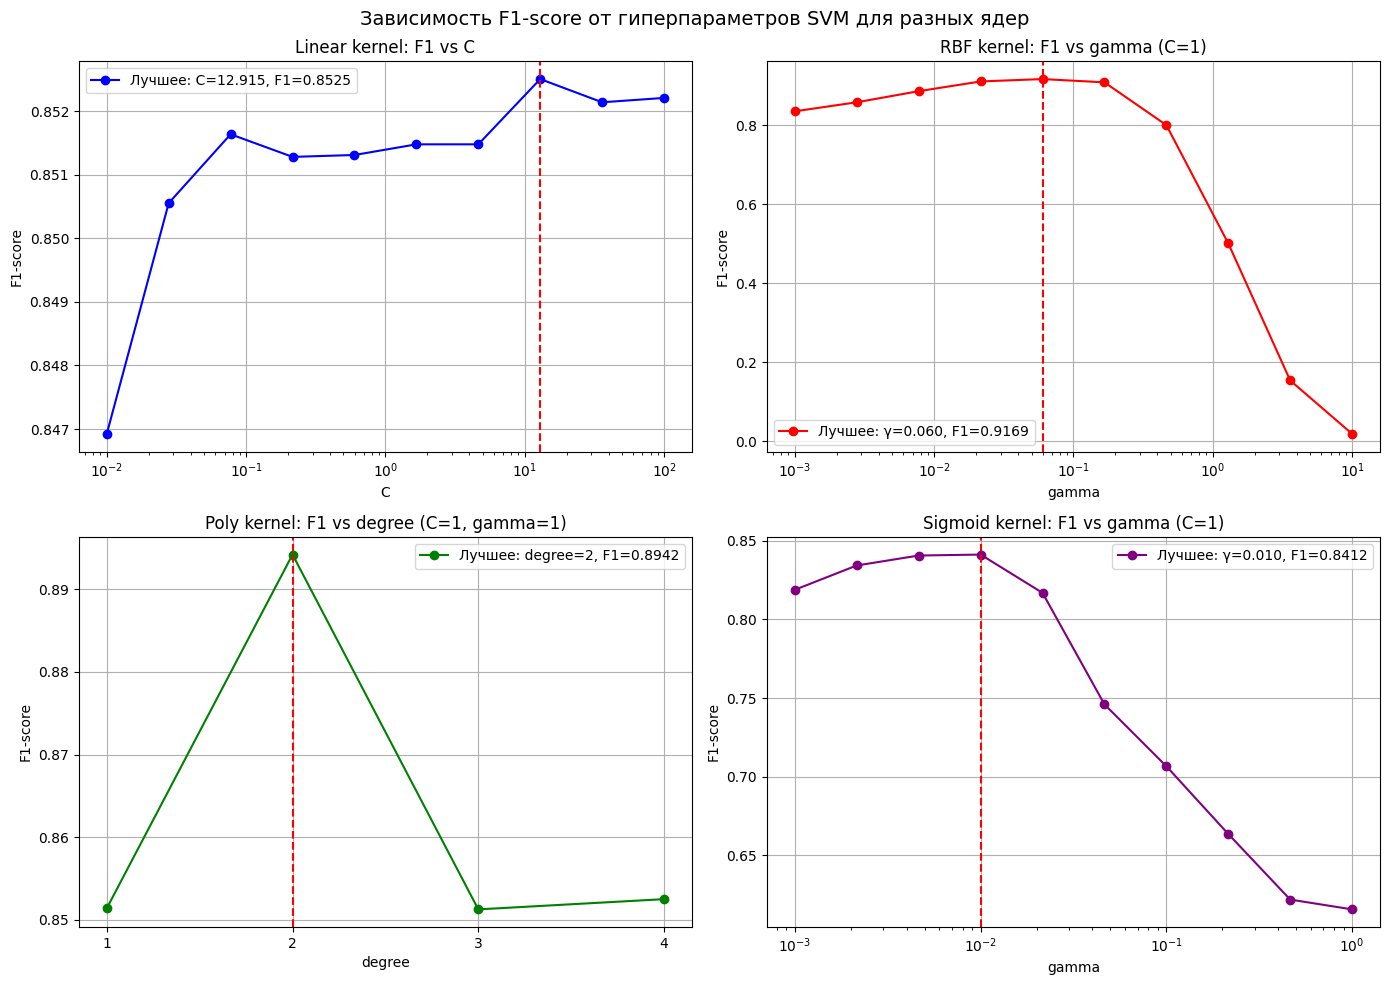


Лучшая модель  SVM с ядром 'rbf':
Accuracy: 0.9426
Precision: 0.9393
Recall: 0.9286
F1: 0.9339
AUC-ROC: 0.9850


In [18]:
X_train_tune, _, y_train_tune, _ = train_test_split(
    X_train_balanced, y_train_balanced,
    train_size=5000,
    random_state=42,
    stratify=y_train_balanced
)

C_values = np.logspace(-2, 2, 10)
f1_linear = []
for C in C_values:
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1 = f1_score(y_test, svm.predict(X_test))
    f1_linear.append(f1)

best_C_linear = C_values[np.argmax(f1_linear)]
best_f1_linear = max(f1_linear)

gamma_rbf = np.logspace(-3, 1, 10)
f1_rbf = []

for g in gamma_rbf:
    svm = SVC(kernel='rbf', C=1.0, gamma=g, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1 = f1_score(y_test, svm.predict(X_test))
    f1_rbf.append(f1)

best_gamma_rbf = gamma_rbf[np.argmax(f1_rbf)]
best_f1_rbf = max(f1_rbf)

degrees = [1, 2, 3, 4]
f1_poly = []

for d in degrees:
    svm = SVC(kernel='poly', C=1.0, gamma=1.0, degree=d, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1 = f1_score(y_test, svm.predict(X_test))
    f1_poly.append(f1)

best_degree_poly = degrees[np.argmax(f1_poly)]
best_f1_poly = max(f1_poly)

gamma_sigmoid = np.logspace(-3, 0, 10)
f1_sigmoid = []

for g in gamma_sigmoid:
    svm = SVC(kernel='sigmoid', C=1.0, gamma=g, random_state=42)
    svm.fit(X_train_tune, y_train_tune)
    f1 = f1_score(y_test, svm.predict(X_test))
    f1_sigmoid.append(f1)

best_gamma_sigmoid = gamma_sigmoid[np.argmax(f1_sigmoid)]
best_f1_sigmoid = max(f1_sigmoid)

results_SVM = {
    'linear': best_f1_linear,
    'rbf': best_f1_rbf,
    'poly': best_f1_poly,
    'sigmoid': best_f1_sigmoid
}
best_kernel = max(results_SVM, key=results_SVM.get)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Зависимость F1-score от гиперпараметров SVM для разных ядер', fontsize=14)

# Linear
axes[0,0].semilogx(C_values, f1_linear, 'o-', color='blue')
axes[0,0].set_title('Linear kernel: F1 vs C')
axes[0,0].set_xlabel('C')
axes[0,0].set_ylabel('F1-score')
axes[0,0].grid(True)

best_f1_linear_val = max(f1_linear)
axes[0,0].axvline(best_C_linear, color='red', linestyle='--')
axes[0,0].legend([f'Лучшее: C={best_C_linear:.3f}, F1={best_f1_linear_val:.4f}']) 

# RBF
axes[0,1].semilogx(gamma_rbf, f1_rbf, 'o-', color='red')
axes[0,1].set_title('RBF kernel: F1 vs gamma (C=1)')
axes[0,1].set_xlabel('gamma')
axes[0,1].set_ylabel('F1-score')
axes[0,1].grid(True)

best_f1_rbf_val = max(f1_rbf)
axes[0,1].axvline(best_gamma_rbf, color='red', linestyle='--')
axes[0,1].legend([f'Лучшее: γ={best_gamma_rbf:.3f}, F1={best_f1_rbf_val:.4f}'])

# Poly
axes[1,0].plot(degrees, f1_poly, 'o-', color='green')
axes[1,0].set_title('Poly kernel: F1 vs degree (C=1, gamma=1)')
axes[1,0].set_xlabel('degree')
axes[1,0].set_ylabel('F1-score')
axes[1,0].set_xticks(degrees)
axes[1,0].grid(True)

best_f1_poly_val = max(f1_poly)
axes[1,0].axvline(best_degree_poly, color='red', linestyle='--')
axes[1,0].legend([f'Лучшее: degree={best_degree_poly}, F1={best_f1_poly_val:.4f}'])


# Sigmoid
axes[1,1].semilogx(gamma_sigmoid, f1_sigmoid, 'o-', color='purple')
axes[1,1].set_title('Sigmoid kernel: F1 vs gamma (C=1)')
axes[1,1].set_xlabel('gamma')
axes[1,1].set_ylabel('F1-score')
axes[1,1].grid(True)

best_f1_sigmoid_val = max(f1_sigmoid)
axes[1,1].axvline(best_gamma_sigmoid, color='red', linestyle='--')
axes[1,1].legend([f'Лучшее: γ={best_gamma_sigmoid:.3f}, F1={best_f1_sigmoid_val:.4f}'])

plt.tight_layout()
plt.show()

if best_kernel == 'linear':
    best_svm = SVC(kernel='linear', C=best_C_linear, random_state=42, probability=True)
elif best_kernel == 'rbf':
    best_svm = SVC(kernel='rbf', C=1.0, gamma=best_gamma_rbf, random_state=42, probability=True)
elif best_kernel == 'poly':
    best_svm = SVC(kernel='poly', C=1.0, gamma=1.0, degree=best_degree_poly, random_state=42, probability=True)
else:
    best_svm = SVC(kernel='sigmoid', C=1.0, gamma=best_gamma_sigmoid, random_state=42, probability=True)


best_svm.fit(X_train_balanced, y_train_balanced)

y_pred_svm_final = best_svm.predict(X_test)
y_proba_svm_final = best_svm.predict_proba(X_test)[:, 1]


metrics_svm_full = {
    'Model': f'SVM ({best_kernel})',
    'Accuracy': accuracy_score(y_test, y_pred_svm_final),
    'Precision': precision_score(y_test, y_pred_svm_final),
    'Recall': recall_score(y_test, y_pred_svm_final),
    'F1': f1_score(y_test, y_pred_svm_final),
    'AUC-ROC': roc_auc_score(y_test, y_proba_svm_final)
}
results.append(metrics_svm_full)

print(f"\nЛучшая модель  SVM с ядром '{best_kernel}':")
for metric, value in metrics_svm_full.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

### e. Метод ближайших соседей
**kNN** - алгоритм классификации, который не строит модель заранее. Вместо этого, при предсказании он ищет в обучающей выборке k самых похожих объектов и принимает решение по их «голосам».

1. При обучении просто запоминает все обучающие данные.
2. При предсказании для нового объекта:
- Вычисляет расстояние от нового объекта до всех объектов в обучающей выборке;
- Выбирает k ближайших (с наименьшим расстоянием);
- Считает, какой класс чаще встречается среди этих k соседей.
- Назначает этот класс новому объекту.

kNN использует метрику расстояния, чтобы определить, какие объекты «ближе». Популярные метрики: евклидова (euclidean), манхэттенская (manhattan), минковского (minkowski).

**Ключевые гиперпараметры:**
- n_neighbors (k) — сколько соседей учитывать при голосовании;
- weights — как учитывать соседей — 'uniform' (все одинаково) или 'distance' (ближайшие важнее)
- metric — метрика расстояния — 'euclidean', 'manhattan', 'minkowski' и др. Для большинства задач с непрерывными признаками подходит 'euclidean'.

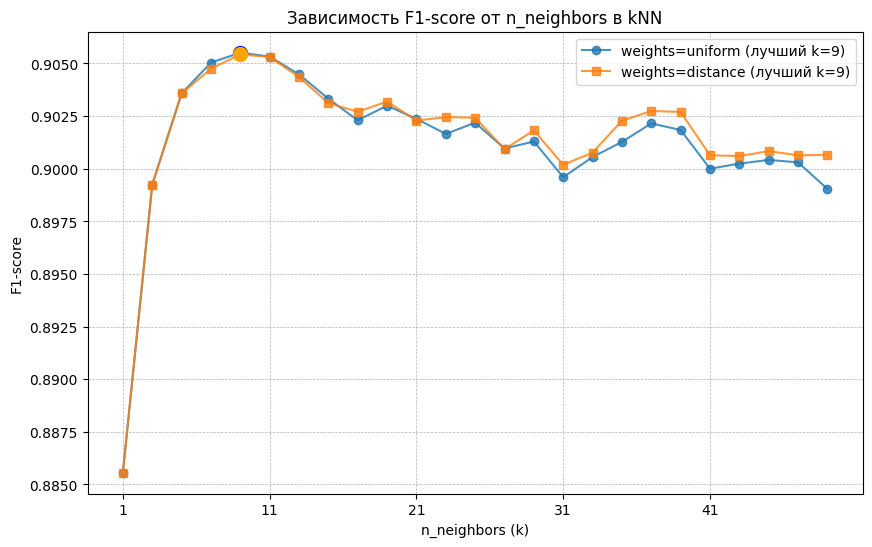


Лучшая модель kNN при weight = uniform, k = 9:
Accuracy: 0.9183
Precision: 0.9149
Recall: 0.8963
F1: 0.9055
AUC-ROC: 0.9688


In [22]:
k_values = np.arange(1, 51, 2)

f1_uniform = []
f1_distance = []

for k in k_values:
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean', n_jobs=-1)
    knn_u.fit(X_train_balanced, y_train_balanced)
    f1_uniform.append(f1_score(y_test, knn_u.predict(X_test)))
    
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)
    knn_d.fit(X_train_balanced, y_train_balanced)
    f1_distance.append(f1_score(y_test, knn_d.predict(X_test)))

best_k_uniform = k_values[np.argmax(f1_uniform)]
best_f1_uniform = max(f1_uniform)

best_k_distance = k_values[np.argmax(f1_distance)]
best_f1_distance = max(f1_distance)

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_uniform, 'o-', label=f'weights=uniform (лучший k={best_k_uniform})', alpha=0.8)
plt.plot(k_values, f1_distance, 's-', label=f'weights=distance (лучший k={best_k_distance})', alpha=0.8)

plt.scatter([best_k_uniform], [best_f1_uniform], color='blue', s=100, zorder=5)
plt.scatter([best_k_distance], [best_f1_distance], color='orange', s=100, zorder=5)

plt.xlabel('n_neighbors (k)')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от n_neighbors в kNN')
plt.legend()
plt.grid(True, ls="--", linewidth=0.5)
plt.xticks(k_values[::5])
plt.show()

if best_f1_uniform >= best_f1_distance:
    best_weights = 'uniform'
    best_k = best_k_uniform
    best_f1_knn = best_f1_uniform
else:
    best_weights = 'distance'
    best_k = best_k_distance
    best_f1_knn = best_f1_distance

knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    metric='euclidean',
    n_jobs=-1
)
knn_best.fit(X_train_balanced, y_train_balanced)

y_pred_knn = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:, 1]

metrics_knn = {
    'Model': f'kNN (k={best_k}, weights={best_weights})',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1': f1_score(y_test, y_pred_knn),
    'AUC-ROC': roc_auc_score(y_test, y_proba_knn)
}

results.append(metrics_knn)

print(f"\nЛучшая модель kNN при weight = {best_weights}, k = {best_k}:")
for metric, value in metrics_knn.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")


## 5. Нейронная сеть на TensorFlow
**Нейронная сеть** — это вычислительная модель, вдохновлённая работой биологического мозга. Она состоит из множества взаимосвязанных искусственных нейронов, организованных в слои. Сеть обучается на данных, постепенно подстраивая свои внутренние параметры (веса), чтобы правильно преобразовывать входные данные (например, признаки пассажира) в желаемый выход (например, «удовлетворён» или «не удовлетворён»).

### Нейронная сеть состоит из трёх типов слоёв:
- Входной слой: принимает исходные признаки (количество нейронов = количеству признаков в данных).
- Скрытые слои: промежуточные слои, в которых происходит «извлечение признаков» и обучение сложных зависимостей. Каждый нейрон в скрытом слое соединён со всеми нейронами предыдущего слоя.
- Выходной слой: выдаёт окончательный результат.

### Функции активации
Функция активации определяет, «сработает» ли нейрон при заданном входе.
1. ReLU (Rectified Linear Unit):

$f(x) = \max(0, x)$

Используется в большинстве скрытых слоёв.

2. Sigmoid (сигмоида):

$f(x) = \frac{1}{1 + e^{-x}}$

Выдаёт значения от 0 до 1. Используется в выходном слое при бинарной классификации.

3. Softmax:

$f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$

Преобразует вектор произвольных вещественных чисел в вектор вероятностей. Используется в выходном слое при многоклассовой классификации. Сумма всех выходов = 1.

4. Tanh (гиперболический тангенс):

$f(x) = \tanh(x)$

Похожа на сигмоиду, но выдаёт значения от –1 до +1. Иногда используется в скрытых слоях.

### Функция потерь
Функция потерь измеряет, насколько предсказание сети отличается от истинного ответа. Выбор зависит от типа классификации.

1. Binary Crossentropy

Используется при бинарной классификации. Штрафует за неверную уверенность в предсказании одного из двух классов.

2. Categorical Crossentropy

Используется при многоклассовой классификации. Обобщение кросс-энтропии на $K>2$ классов. Требует метки в виде one-hot векторов (способ кодирования категориальных переменных, при котором каждый возможный класс (категория) представляется в виде вектора, в котором: один элемент равен 1 («горячий»),
все остальные — 0).

3. Sparse Categorical Crossentropy

Ипользуется при многокласовой (альтернатива). Метки задаются как целые числа
(0, 1, 2, ...), а не one-hot.

### Оптимизатор
Оптимизатор обновляет веса сети, чтобы минимизировать функцию потерь. Наиболее распространённый:

1. Adam

Для каждого параметра отдельно оценивает:
- Первый момент (среднее) градиента → как Momentum (техника улучшения градиентного спуска в обучении нейронных сетей).
- Второй момент (дисперсия) градиента → насколько «шумный» градиент.

Адаптивно уменьшает скорость обучения для параметров с большими градиентами и увеличивает для стабильных.

### Ключевые гиперпараметры:
- epochs (число эпох) — сколько раз сеть «пройдёт» по всему обучающему датасету;
- batch_size (размер батча) — количество объектов, обрабатываемых за один шаг обучения (32, 64, 128 и т.д.);
- количество скрытых слоёв — определяет «глубину» сети. Больше слоёв → больше выразительной мощности, но выше риск переобучения;
- количество нейронов — влияет на ёмкость модели. Обычно уменьшается к выходу (например: 128 → 64 → 32).
- activation — функция активации

### Эксперименты с гиперпараметрами:
1. Число эпох
- Меняется: epochs ∈ [5, 10, ..., 30]
- Фиксированные значения: batch_size = 64, hidden_layers=[64,32], activation='relu', dropout=0.3, lr=0.001

2. Размер батча
Меняется: batch_size ∈ [16, 32, ..., 256]
- Фиксированные значения: epochs=20, hidden_layers=[64,32], activation='relu', dropout=0.3, lr=0.001

3. Количество/структура слоёв
Меняется: hidden_layers ∈ [[64], [64,64], ...]
- Фиксированные значения: epochs=20, batch_size=64, activation='relu', dropout=0.3, lr=0.001

4. Количество нейронов
Меняется: hidden_layers ∈ [[32,16], [64,32], ...]
- Фиксированные значения: epochs=20, batch_size=64, activation='relu', dropout=0.3, lr=0.001

5. Функция активации
Меняется: activation ∈ ['relu', 'tanh', 'sigmoid']
- Фиксированные значения: epochs=20, batch_size=64, hidden_layers=[64,32], dropout=0.3, lr=0.001


In [11]:
X_train_nn = X_train_balanced  # уже сбалансированная и обработанная
X_test_nn = X_test
y_train_nn = y_train_balanced.astype(int)
y_test_nn = y_test.astype(int)

# Параметры модели
input_dim = X_train_nn.shape[1]
num_classes = 1  # бинарная классификация → выход 1 нейрон с sigmoid

def create_nn_model(hidden_layers=[64, 32], dropout_rate=0.3, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    # Бинарная классификация → 1 нейрон + sigmoid
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',  # ← важно: не sparse_categorical!
        metrics=['accuracy']
    )
    return model

# Папка для логов TensorBoard
log_base_dir = "logs"
if os.path.exists(log_base_dir) and not os.path.isdir(log_base_dir):
    os.remove(log_base_dir)
os.makedirs(log_base_dir, exist_ok=True)

# Сетка гиперпараметров
param_grid = {
    'hidden_layers': [[64], [128, 64], [64, 32], [256, 128, 64]],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01]
}

best_f1 = -1
best_model = None
best_history = None
best_params = None

print("\nПодбор гиперпараметров для нейросети (бинарная классификация)")

for hidden_layers, dropout_rate, lr in product(
    param_grid['hidden_layers'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
):
    print(f"\nТестируем: layers={hidden_layers}, dropout={dropout_rate}, lr={lr}")
    
    # Уникальное имя для TensorBoard
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_name = f"nn_hl{'_'.join(map(str, hidden_layers))}_dr{dropout_rate}_lr{lr}_{timestamp}"
    log_dir = os.path.join(log_base_dir, run_name)
    os.makedirs(log_dir, exist_ok=True)
    
    # Callback
    tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Создание и обучение модели
    model = create_nn_model(
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        learning_rate=lr
    )
    
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_test_nn, y_test_nn),
        epochs=30,          # можно уменьшить для скорости
        batch_size=64,      # или 128
        callbacks=[tensorboard_cb],
        verbose=0
    )
    
    # Оценка F1
    y_pred_proba = model.predict(X_test_nn, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    f1 = f1_score(y_test_nn, y_pred)
    
    print(f"F1-score: {f1:.4f}")
    
    # Сохраняем лучшую модель
    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_history = history
        best_params = {
            'hidden_layers': hidden_layers,
            'dropout_rate': dropout_rate,
            'learning_rate': lr
        }

# Финальные предсказания и метрики
y_pred_best = (best_model.predict(X_test_nn, verbose=0).flatten() > 0.5).astype(int)
y_proba_best = best_model.predict(X_test_nn, verbose=0).flatten()

acc = accuracy_score(y_test_nn, y_pred_best)
prec = precision_score(y_test_nn, y_pred_best)
rec = recall_score(y_test_nn, y_pred_best)
f1 = f1_score(y_test_nn, y_pred_best)
auc = roc_auc_score(y_test_nn, y_proba_best)

# Сохраняем в общий список (если у вас есть `results`)
metrics_nn = {
    'Model': 'Neural Network',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC-ROC': auc
}

# Если у вас есть общий список моделей — добавьте:
# results.append(metrics_nn)

print("\n✅ Лучшая нейросеть:")
print(f"Параметры: {best_params}")
print(f"F1-score на тесте: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


Подбор гиперпараметров для нейросети (бинарная классификация)

Тестируем: layers=[64], dropout=0.2, lr=0.001


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} logs\nn_hl64_dr0.2_lr0.001_20251101-210941 is not a directory [Op:CreateSummaryFileWriter] name: 